In [1]:
%load_ext autoreload
%autoreload 2

import scipy.io.wavfile as wav
import pyaudio
import wave
from playsound import playsound

import sys

import numpy as np
import matplotlib
import matplotlib.pylab as plt
import scipy
import healpy as hp

from numpy import random
from scipy import signal
from scipy.stats import norm

from savetimeseries import *
from plottimeseries import *
from plothistogram import *
from plotpowerspectrum import *
from playsoundfile import *

from pulsar_routines import calculate_klm, calculate_phat, calculate_EpEc, calculate_Dab, calculate_FpFc, calculate_Fss

%matplotlib inline

In [2]:
matplotlib.rcParams.update({'font.size':12})
#matplotlib.rcParams['figure.dpi'] = 150
#matplotlib.rcParams['figure.figsize'] = [5,3]
matplotlib.rcParams['text.usetex'] = True

In [7]:
# test routine

# GW directions
NSIDE = 32
NPIX = hp.nside2npix(NSIDE)
IPIX = np.arange(NPIX)
theta_gw, phi_gw = hp.pix2ang(nside=NSIDE,ipix=IPIX)

# pulsar locations
theta_p = np.deg2rad([60, 90])
phi_p = np.deg2rad([225, 135])

khat, lhat, mhat = calculate_klm(theta_gw, phi_gw)
print(khat.shape)
print(khat[:,0])

ep, ec = calculate_EpEc(theta_gw, phi_gw)
print(ep.shape)
print(ep[:,:,0])

Dab = calculate_Dab(theta_p, phi_p, theta_gw, phi_gw)
print(Dab.shape)
print(Dab[:,:,0,0])

Fp, Fc = calculate_FpFc(theta_p, phi_p, theta_gw, phi_gw)
print(Fp.shape)
print(Fp[:,0])

(3, 12288)
[-0.01804073 -0.01804073 -0.99967448]
(3, 3, 12288)
[[ 3.25467851e-04 -9.99674532e-01  1.80348549e-02]
 [-9.99674532e-01  3.25467851e-04  1.80348549e-02]
 [ 1.80348549e-02  1.80348549e-02 -6.50935703e-04]]
(3, 3, 2, 12288)
[[ 0.35901792  0.35901792 -0.29313691]
 [ 0.35901792  0.35901792 -0.29313691]
 [-0.29313691 -0.29313691  0.23934528]]
(2, 12288)
[-0.73887098  0.5       ]


0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


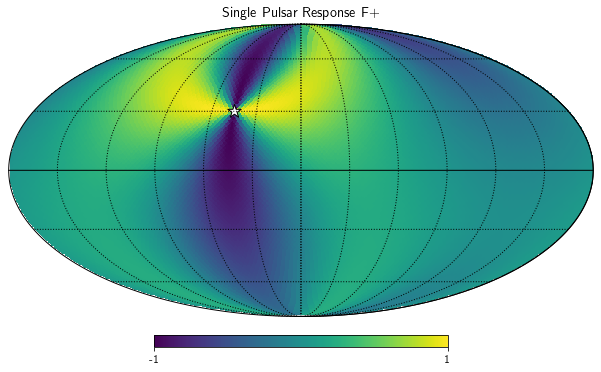

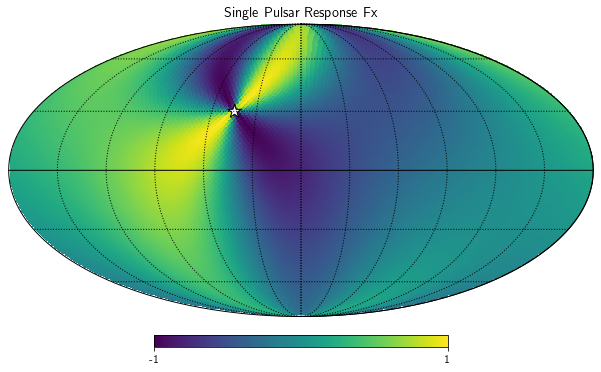

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


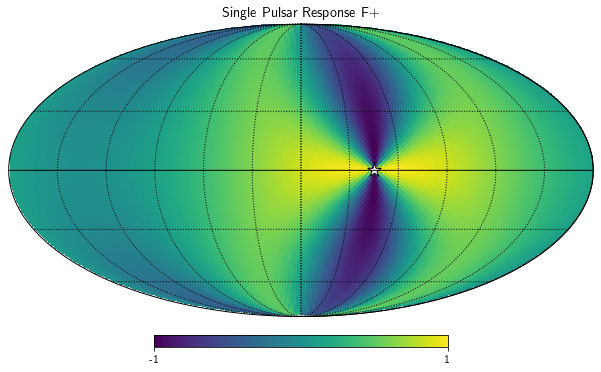

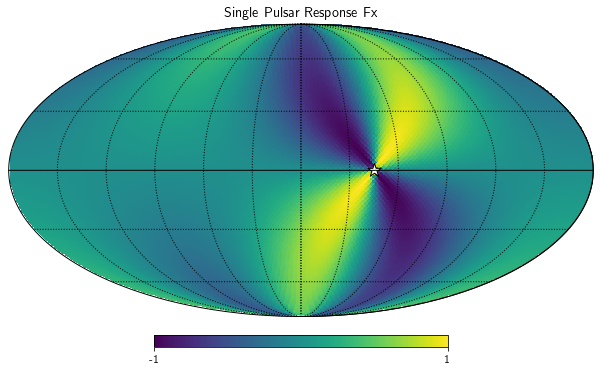

In [8]:
# plot F+, Fx response

# convenient pulsar locations
theta_p = np.deg2rad([60, 90])
phi_p = np.deg2rad([225, 135])

# calculate F+, Fx
Fp, Fc = calculate_FpFc(theta_p, phi_p, theta_gw, phi_gw)

idx=0
hp.mollview(Fp[idx],rot=(180,0,0),title="Single Pulsar Response F+",min=-1,max=1)
hp.projscatter(theta_p[idx],phi_p[idx],marker='*',color='white',edgecolors='k',s=200)
hp.graticule()
hp.mollview(Fc[idx],rot=(180,0,0),title="Single Pulsar Response Fx",min=-1,max=1)
hp.projscatter(theta_p[idx],phi_p[idx],marker='*',color='white',edgecolors='k',s=200)
hp.graticule()
plt.show()

idx=1
hp.mollview(Fp[idx],rot=(180,0,0),title="Single Pulsar Response F+",min=-1,max=1)
hp.projscatter(theta_p[idx],phi_p[idx],marker='*',color='white',edgecolors='k',s=200)
hp.graticule()
hp.mollview(Fc[idx],rot=(180,0,0),title="Single Pulsar Response Fx",min=-1,max=1)
hp.projscatter(theta_p[idx],phi_p[idx],marker='*',color='white',edgecolors='k',s=200)
hp.graticule()
plt.show()

0.0 180.0 -180.0 180.0


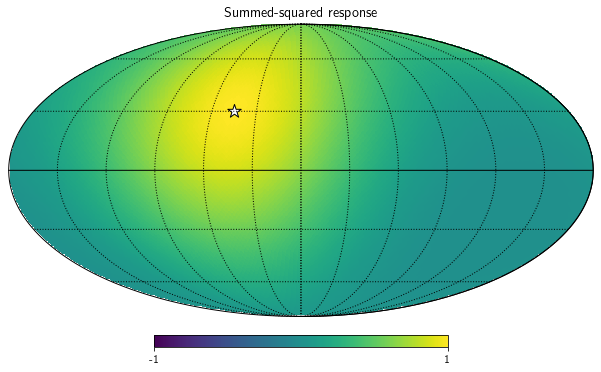

0.0 180.0 -180.0 180.0


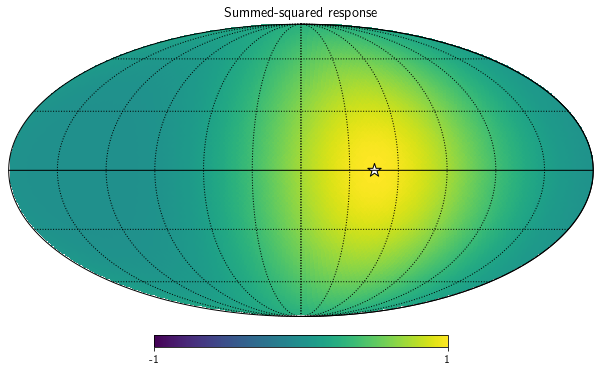

In [9]:
# convenient pulsar locations
theta_p = np.deg2rad([60, 90])
phi_p = np.deg2rad([225, 135])

# calculate F+, Fx
Fss = calculate_Fss(theta_p, phi_p, theta_gw, phi_gw)

idx=0
hp.mollview(Fss[idx],rot=(180,0,0),title="Summed-squared response",min=-1,max=1)
hp.projscatter(theta_p[idx],phi_p[idx],marker='*',color='white',edgecolors='k',s=200)
hp.graticule()
plt.show()

idx=1
hp.mollview(Fss[idx],rot=(180,0,0),title="Summed-squared response",min=-1,max=1)
hp.projscatter(theta_p[idx],phi_p[idx],marker='*',color='white',edgecolors='k',s=200)
hp.graticule()
plt.show()

# Routines to generate different types of signals

In [82]:
x=np.array([1, 2, 3])
print(x,np.shape(x))
y = x[np.newaxis,:]
print(y,np.shape(y))

z=1
np.ravel(z)
print(z)

[1 2 3] (3,)
[[1 2 3]] (1, 3)
1


In [100]:
def planewave_superposition(Nsources, A, f, phase, theta, phi, x_detector, c, tmin, tmax):
    
    '''
    Ns: number of sources
    A: array of amplitudes
    f: array of frequencies
    phase: array of phases (radians)
    theta, phi: array of directions to the sources
    x_detector: 3-d vector position vector of the detector
    c: wave speed
    tmin, tmax: start and stop time of the observation
    '''
    
    # discrete times
    Fs = 22500. # sampling rate
    deltaT = 1./Fs
    Nt = int(tmax/deltaT)
    t = np.linspace(tmin, tmax, Nt)
    
    # first convert theta, phi into individual arrays, even if individual floats
    theta = np.ravel(theta)
    phi = np.ravel(phi)
    
    # construct 3xNs array of source directions
    nhat = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
    khat = -nhat # direction of wave propagation
    print(khat)

    # dot produce with detector position vector (Ns array)
    kdotx = np.einsum('ij, i->j', khat, x_detector)
    print(kdotx)
    
    # construct plane waves NsxNt
    temp = t[np.newaxis, :] - kdotx[:,np.newaxis]/c 
    arg = 2*np.pi*np.einsum('i, ik -> ik', f,temp) + phi[:,np.newaxis]
    r = np.einsum('i, ik -> ik', A, np.cos(arg))
    
    # sum over sources
    rsum = np.sum(r, axis=0)
    
    return t, r, rsum

[[-1.000000e+00 -6.123234e-17]
 [-0.000000e+00 -1.000000e+00]
 [-6.123234e-17 -6.123234e-17]]
[-2.0000000e+00 -1.2246468e-16]


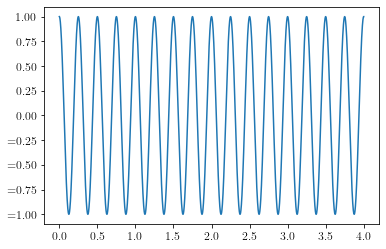

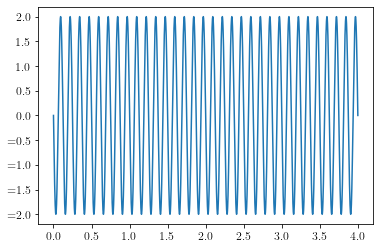

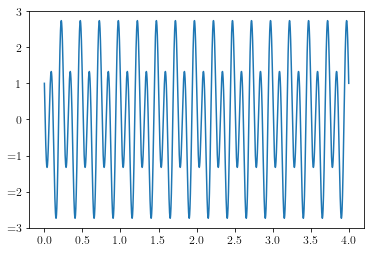

In [102]:
# test routines
Fs = 22500
Ns = 2
A = np.array([1,2])
f = np.array([4,8])
phase = np.array([0,90])
theta = np.deg2rad([90,90])
phi = np.deg2rad([0,90])
det1 = np.array([2, 0, 0])
det2 = np.array([-2, 2, 0])
det3 = np.array([0, 0, 0])
c = 4
t1 = 0
t2 = 4
t0 = 2
width = 0.1
t, r, rsum = planewave_superposition(Ns, A, f, phase, theta, phi, det1, c, t1, t2)


for ii in range(Ns):
    plt.figure()
    plt.plot(t,r[ii])
    
plt.figure()
plt.plot(t,rsum)

In [56]:
def planewave(A, f, phase, theta, phi, x_detector, c, tmin, tmax):
    
    '''
    A: amplitude
    f: frequency
    phase: phase (radians)
    theta, phi: direction to the source of the wave
    x_detector: 3-d vector position vector of the detector
    c: wave speed
    tmin, tmax: start and stop time of the wave
    '''
    
    Fs = 22500. # sampling rate
    deltaT = 1./Fs
    N = int(tmax/deltaT)
    t = np.linspace(tmin, tmax, N)
    
    nhat = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
    khat = -nhat # direction of wave propagation

    kdotx = np.dot(khat,x_detector)
    
    r = A*np.cos(2*np.pi*f*(t - kdotx/c) + phi)
    
    return t, r

In [58]:
def planewave_pulse(A, f, phase, theta, phi, t0, width, x_detector, c, tmin, tmax):
    
    '''
    A: amplitude
    f: frequency
    phase: phase (radians)
    theta, phi: direction to the source of the wave
    t0: center time of pulse
    width: pulse width
    x_detector: 3-d vector position vector of the detector
    c: wave speed
    tmin, tmax: start and stop time of the wave
    '''
    
    nhat = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
    khat = -nhat # direction of wave propagation

    kdotx = np.dot(khat,x_detector)
    
    # pure plane wave
    t, r = planewave(A, f, phase, theta, phi, x_detector, c, tmin, tmax)
    
    # modulated by a gaussian envelope
    r = r*np.exp(-(t-kdotx/c - t0)**2 / (2*width**2))
    
    return t, r

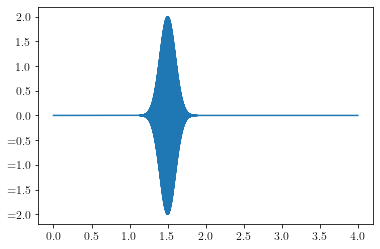

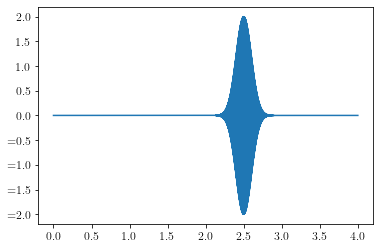

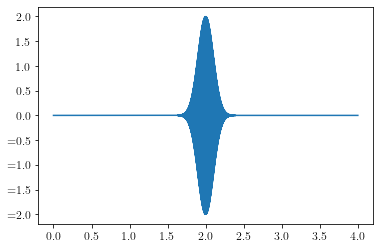

In [73]:
# test routines
Fs = 22500
A = 2
f = 440
phase = 0
theta = np.deg2rad(90)
phi = np.deg2rad(0)
det1 = np.array([2, 0, 0])
det2 = np.array([-2, 2, 0])
det3 = np.array([0, 0, 0])
c = 4
t1 = 0
t2 = 4
t0 = 2
width = 0.1

t, r1 = planewave(A, f, phase, theta, phi, det1, c, t1, t2)
t, r2 = planewave(A, f, phase, theta, phi, det2, c, t1, t2)
t, r3 = planewave(A, f, phase, theta, phi, det3, c, t1, t2)

t, r1 = planewave_pulse(A, f, phase, theta, phi, t0, width, det1, c, t1, t2)
t, r2 = planewave_pulse(A, f, phase, theta, phi, t0, width, det2, c, t1, t2)
t, r3 = planewave_pulse(A, f, phase, theta, phi, t0, width, det3, c, t1, t2)

plt.figure()
plt.plot(t,r1)
plt.figure()
plt.plot(t,r2)
plt.figure()
plt.plot(t,r3)

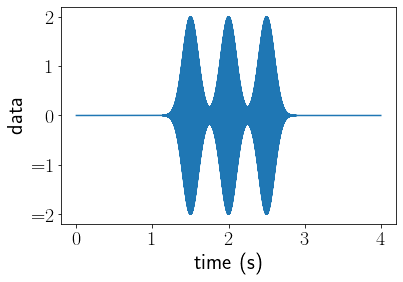

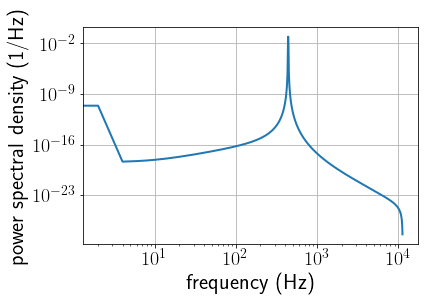

In [74]:
fileprefix = 'planewave'
r = r1 + r2 + r3
savetimeseries(t, r, fileprefix)
playsoundfile(fileprefix)
plottimeseries(t, r, t1, t2, fileprefix)
plotpowerspectrum(t, r, t1, t2, Fs, fileprefix)

0.0 180.0 -180.0 180.0


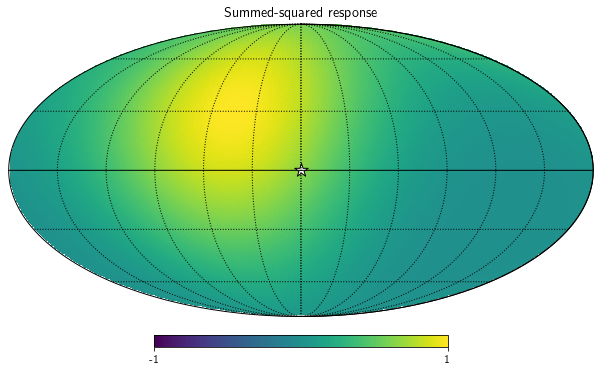

12288 12288


In [78]:
# make sky map of sources
# GW directions
NSIDE = 32
NPIX = hp.nside2npix(NSIDE)
IPIX = np.arange(NPIX)
theta_gw, phi_gw = hp.pix2ang(nside=NSIDE,ipix=IPIX)

# source locations
theta = np.deg2rad(90)
phi = np.deg2rad(180)

idx=0
hp.mollview(Fss[idx],rot=(180,0,0),title="Summed-squared response",min=-1,max=1)
hp.projscatter(theta,phi,marker='*',color='white',edgecolors='k',s=200)
hp.graticule()
plt.show()

print(len(theta_gw), NPIX)

In [2]:
def puretone(tmin, tmax, f0):
    
    Fs = 22500. # sampling rate
    deltaT = 1./Fs
    N = int(tmax/deltaT)
    t = np.linspace(tmin, tmax, N)

    y = np.sin(2*np.pi*f0*t) 
    
    return t, y

In [3]:
def whitenoise(tmin, tmax, var):
    
    Fs = 22500. # sampling rate
    deltaT = 1./Fs
    N = int(tmax/deltaT)
    t = np.linspace(tmin, tmax, N)
    
    y = random.normal(0,var,N)
    
    return t, y

In [4]:
def ringdown(tmin, tmax, A, f0, Q, lambda_poisson):
    
    Fs = 22500. # sampling rate
    deltaT = 1./Fs
    N = int(tmax/deltaT)
    t = np.linspace(tmin, tmax, N)
    
    if lambda_poisson==0: # special case
        
        t0 = 0.5*(tmin + tmax)
        y = np.zeros(N)
        indices = np.where(t>=t0)[0]
        y[indices[0]-1:-1] = A*np.exp(-2.*np.pi*f0*(t[indices]-t0)/Q)*np.cos(2.*np.pi*f0*(t[indices]-t0))                

    else: # multiple ringdowns
        
        # determine total number of burst to simulate
        Nbursts = random.poisson(lambda_poisson)
    
        # determine random arrival times and amplitudes
        t0 = random.uniform(0, tmax, Nbursts)
        t0 = np.sort(t0)
        AI = random.uniform(A-0.5, A+0.5, Nbursts)
    
        y  = np.zeros(N)    
        for ii in range(0,Nbursts):
            
            indices = np.where(t>=t0[ii])[0]
            
            temp = np.zeros(N)
            temp[indices[0]-1:-1] = AI[ii]*np.exp(-2.*np.pi*f0*(t[indices]-t0[ii])/Q)*np.cos(2.*np.pi*f0*(t[indices]-t0[ii]))
            y = y + temp
            
    return t, y

In [5]:
def chirp(tmin, tmax, A, mass, fcut, lambda_poisson):
    
    Fs = 22500. # sampling rate
    deltaT = 1./Fs
    N = int(tmax/deltaT)
    t = np.linspace(tmin, tmax, N)
    
    # chirp mass
    m = mass*5.e-6 # m1=m2=mass solar masses(in seconds)
    Mc = m/pow(2,1./5.) 
    
    if lambda_poisson==0: # special case
        t0 = 0.5*(tmin + tmax)
        
        tau = t0 - t
        indices1 = np.where(tau>0)[0]
        
        f = np.zeros(N)
        f[indices1] = (1./(2.*np.pi*pow(Mc,5./8.)))*(5./8.)*(1./pow(tau[indices1],3./8.))
        
        indices2 = np.where(f>=fcut)[0]
        indices = list(set(indices1) & set(indices2))
    
        phi = -pow(tau[indices]/Mc, 5./8.)
        # amp = 1 for BNS one second before coalescence
        amp =  A * pow(Mc/(1.21877078861*5.e-6), 5./3.) / pow(tau[indices], 0.25) 
    
        y = np.zeros(N)
        y[indices] = amp * np.sin(phi)
        
    else:
        # determine total number of burst to simulate
        Nbursts = random.poisson(lambda_poisson)
    
        # determine random arrival times and amplitudes
        t0 = random.uniform(0, tmax, Nbursts)
        t0 = np.sort(t0)
        AI = random.uniform(A-0.5, A+0.5, Nbursts)
        
        y  = np.zeros(N)    
        for ii in range(0,Nbursts):
            
            tau = t0[ii] - t
            indices1 = np.where(tau>0)[0]
        
            f = np.zeros(N)
            f[indices1] = (1./(2.*np.pi*pow(Mc,5./8.)))*(5./8.)*(1./pow(tau[indices1],3./8.))
        
            indices2 = np.where(f>=fcut)[0]
            indices = list(set(indices1) & set(indices2))
    
            phi = -pow(tau[indices]/Mc, 5./8.)
            # amp = 1 for BNS one second before coalescence
            amp =  AI[ii] * pow(Mc/(1.21877078861*5.e-6), 5./3.) / pow(tau[indices], 0.25)
    
            temp = np.zeros(N)
            temp[indices] = amp * np.sin(phi)
            
            y = y + temp
        
    return t, y

# Generate signals

# pure tone - deterministic signal

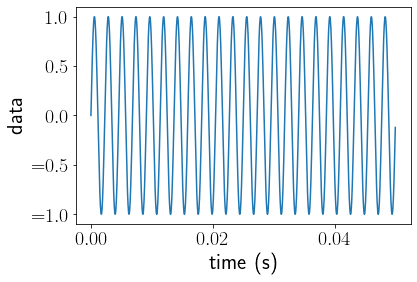

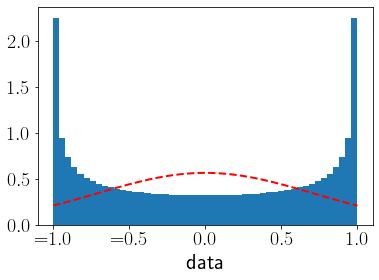

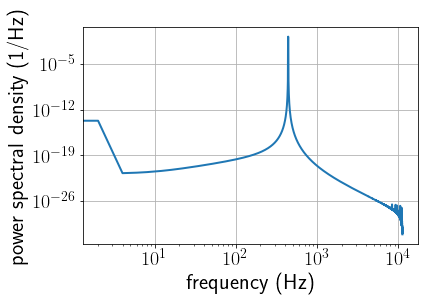

In [6]:
# pure tone
fileprefix = 'puretone'
tmin = 0
tmax = 4.
f0 = 440.
t1 = tmin
t2 = 0.05
Fs = 22500.

t, y = puretone(tmin, tmax, f0)
savetimeseries(t, y, fileprefix)
playsoundfile(fileprefix)
plottimeseries(t, y, t1, t2, fileprefix)
plothistogram(t, y, t[0], t[-1], fileprefix) 
plotpowerspectrum(t, y, tmin, tmax, Fs, fileprefix)

# white noise

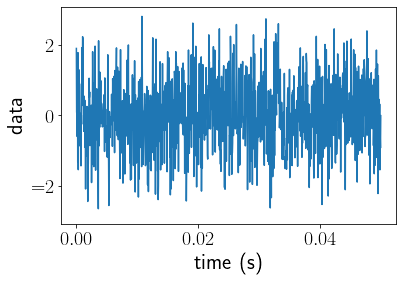

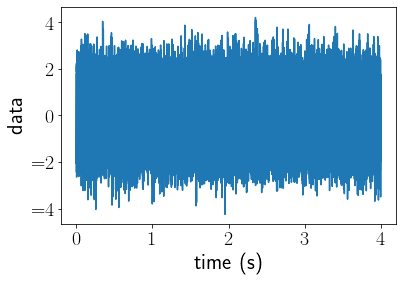

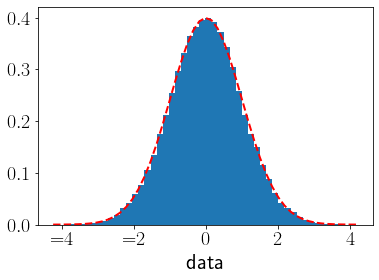

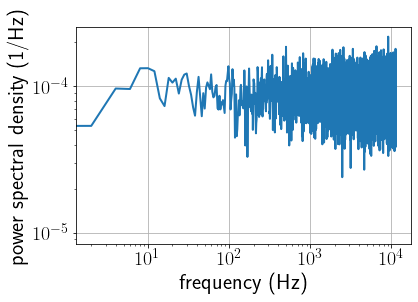

In [7]:
# white noise
random.seed(31459)
fileprefix = 'whitenoise'
tmin = 0
tmax = 4.
var = 1.
t1 = tmin
t2 = 0.05
Fs = 22500.

t, y = whitenoise(tmin, tmax, var)
savetimeseries(t, y, fileprefix)
playsoundfile(fileprefix)
plottimeseries(t, y, t1, t2, 'whitenoise_zoom')
plottimeseries(t, y, tmin, tmax, fileprefix)
plothistogram(t, y, tmin, tmax, fileprefix)
plotpowerspectrum(t, y, tmin, tmax, Fs, fileprefix)

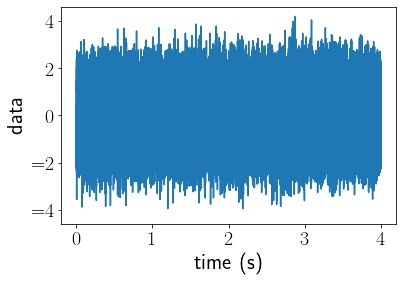

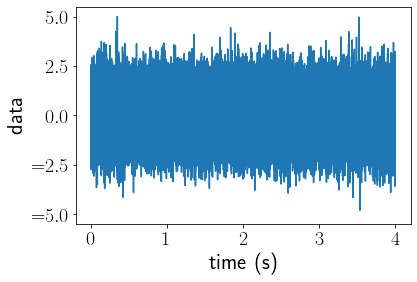

In [8]:
# white noise (two more realizations for two detectors, 4 seconds)
random.seed(1234)
fileprefix = 'whitenoise_det1'
tmin = 0
tmax = 4.
var = 1.
Fs = 22500.

t, y = whitenoise(tmin, tmax, var)
savetimeseries(t, y, fileprefix)
playsoundfile(fileprefix)
plottimeseries(t, y, tmin, tmax, fileprefix)

random.seed(4321)
fileprefix = 'whitenoise_det2'
tmin = 0
tmax = 4.
var = 1.
Fs = 22500.

t, y = whitenoise(tmin, tmax, var)
savetimeseries(t, y, fileprefix)
playsoundfile(fileprefix)
plottimeseries(t, y, tmin, tmax, fileprefix)

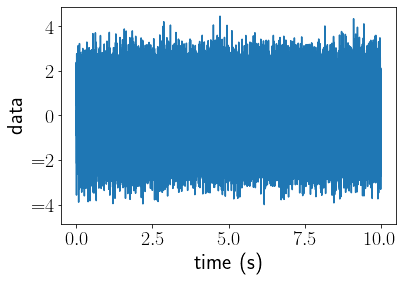

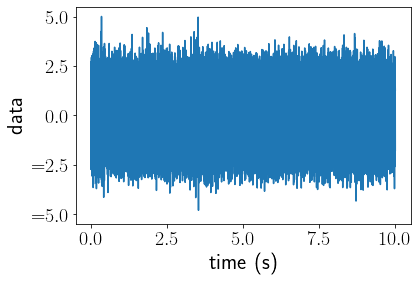

In [9]:
# white noise (two more realizations for two detectors, 10 seconds)
random.seed(1234)
fileprefix = 'whitenoise_det1_10sec'
tmin = 0
tmax = 10.
var = 1.
Fs = 22500.

t, y = whitenoise(tmin, tmax, var)
savetimeseries(t, y, fileprefix)
playsoundfile(fileprefix)
plottimeseries(t, y, tmin, tmax, fileprefix)

random.seed(4321)
fileprefix = 'whitenoise_det2_10sec'
tmin = 0
tmax = 10.
var = 1.
Fs = 22500.

t, y = whitenoise(tmin, tmax, var)
savetimeseries(t, y, fileprefix)
playsoundfile(fileprefix)
plottimeseries(t, y, tmin, tmax, fileprefix)

# BNS chirp signals

chirp duration = 4.849686469131055


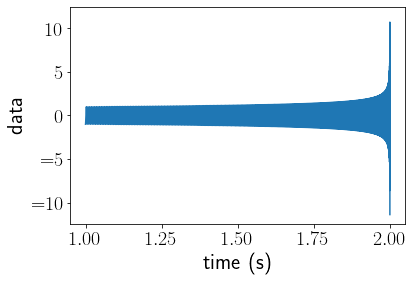

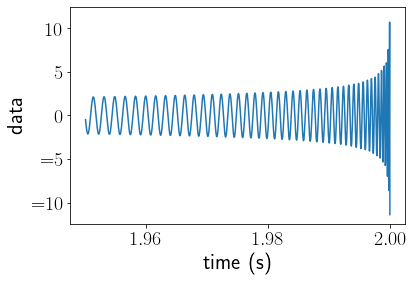

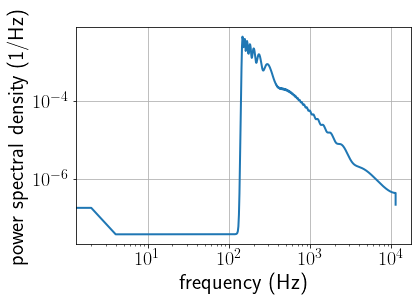

In [10]:
# single BNS chirp
fileprefix = 'chirpBNS'
tmin = 0
tmax = 4.
A = 1
mass = 1.4 # BNS
t0 = 0.5*(tmin+tmax)
fcut = 100.
lambda_poisson = 0
Fs = 22500.

# calculate chirp duration (depends on Mc and fcut)
m = mass*5.e-6 # m1=m2=mass solar masses(in seconds)
Mc = m/pow(2,1./5.)     
tau = 1./pow(2.*np.pi*(8./5.)*pow(Mc,5./8.)*fcut,8./3.)
print('chirp duration =', tau)

t, y = chirp(tmin, tmax, A, mass, fcut, lambda_poisson)
savetimeseries(t, y, fileprefix)
playsoundfile(fileprefix)
plottimeseries(t, y, t0-1.0, t0, fileprefix)
plottimeseries(t, y, t0-0.05, t0, fileprefix+'_zoom')
plotpowerspectrum(t, y, tmin, tmax, Fs, fileprefix)

chirp duration = 4.849686469131055


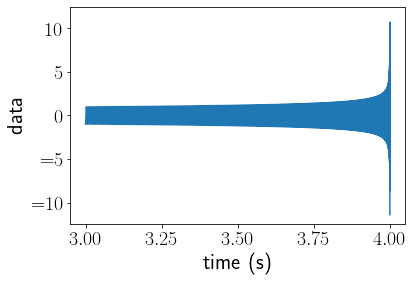

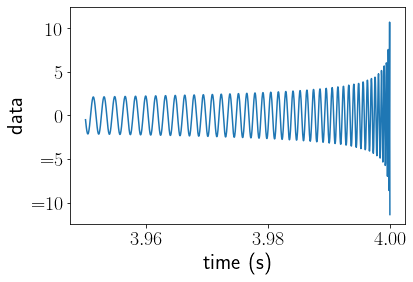

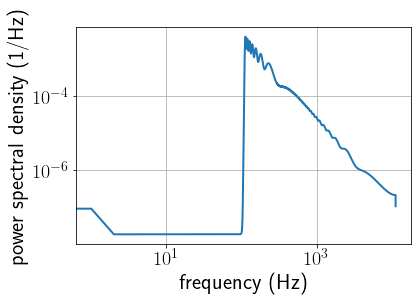

In [11]:
# single BNS chirp (full duration chirp)
fileprefix = 'chirpBNS_full'
tmin = 0
tmax = 8.
A = 1
mass = 1.4 # BNS
t0 = 0.5*(tmin+tmax)
fcut = 100.
lambda_poisson = 0
Fs = 22500.

# calculate chirp duration (depends on Mc and fcut)
m = mass*5.e-6 # m1=m2=mass solar masses(in seconds)
Mc = m/pow(2,1./5.)     
tau = 1./pow(2.*np.pi*(8./5.)*pow(Mc,5./8.)*fcut,8./3.)
print('chirp duration =', tau)

t, y = chirp(tmin, tmax, A, mass, fcut, lambda_poisson)
savetimeseries(t, y, fileprefix)
playsoundfile(fileprefix)
plottimeseries(t, y, t0-1.0, t0, fileprefix)
plottimeseries(t, y, t0-0.05, t0, fileprefix+'_zoom')
plotpowerspectrum(t, y, tmin, tmax, Fs, fileprefix)

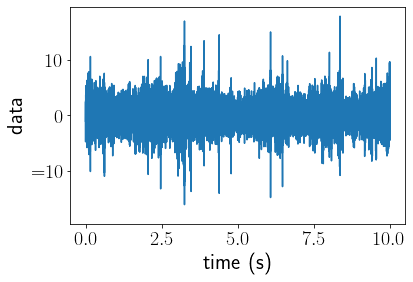

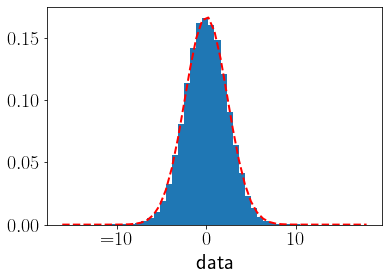

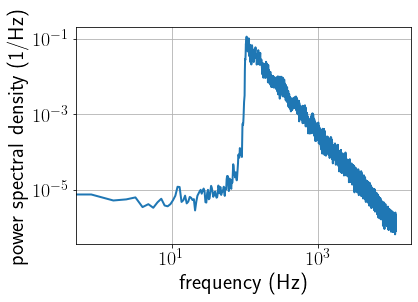

In [12]:
# BNS chirp (25 in 10 sec)
random.seed(31459)
fileprefix = 'chirpBNS25_10s'
tmin = 0
tmax = 10.
A = 1.
mass = 1.4
fcut = 100.
lambda_poisson = 25.
Fs = 22500.

# simulate data of twice duration since duration of each chirp is > tmax
tt, yy = chirp(tmin, 2.*tmax, A, mass, fcut, 2.*lambda_poisson)
t = tt[0:int(len(tt)/2.)]
y = yy[0:int(len(tt)/2.)]
savetimeseries(t, y, fileprefix)
playsoundfile(fileprefix)
plottimeseries(t, y, t[0], t[-1], fileprefix)
plothistogram(t, y, t[0], t[-1], fileprefix) 
plotpowerspectrum(t, y, t[0], t[-1], Fs, fileprefix)

/var/folders/mm/kvzrm4_d52z6vkt_1fl8thrh0000gn/T/ipykernel_75094/2657805723.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  t = tt[0:np.int(len(tt)/2.)]
/var/folders/mm/kvzrm4_d52z6vkt_1fl8thrh0000gn/T/ipykernel_75094/2657805723.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current us

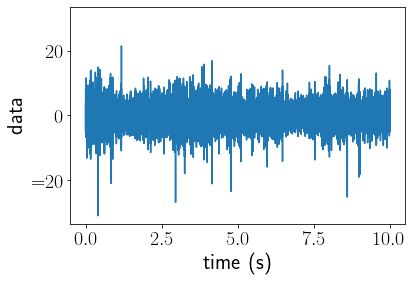

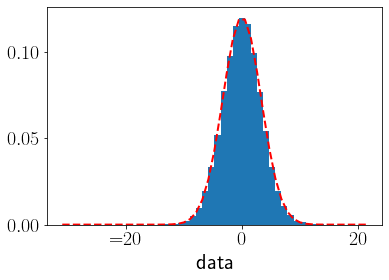

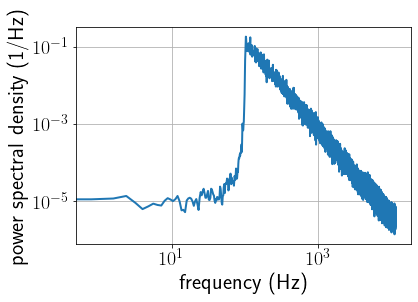

In [13]:
# BNS chirp (50 in 10 sec)
random.seed(31459)
fileprefix = 'chirpBNS50_10s'
tmin = 0
tmax = 10.
A = 1.
mass = 1.4
fcut = 100.
lambda_poisson = 50.
Fs = 22500.

# simulate data of twice duration since duration of each chirp is > tmax
tt, yy = chirp(tmin, 2.*tmax, A, mass, fcut, 2.*lambda_poisson)
t = tt[0:int(len(tt)/2.)]
y = yy[0:int(len(tt)/2.)]
savetimeseries(t, y, fileprefix)
playsoundfile(fileprefix)
plottimeseries(t, y, t[0], t[-1], fileprefix)
plothistogram(t, y, t[0], t[-1], fileprefix) 
plotpowerspectrum(t, y, t[0], t[-1], Fs, fileprefix)

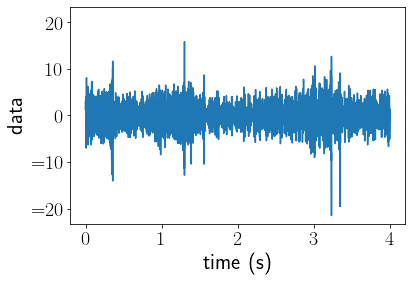

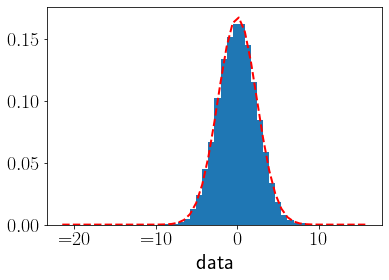

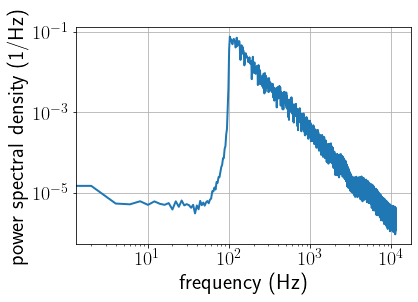

In [14]:
# BNS chirp (10)
random.seed(31459)
fileprefix = 'chirpBNS10'
tmin = 0
tmax = 4.
A = 1.
mass = 1.4
fcut = 100.
lambda_poisson = 10.
Fs = 22500.

# simulate data of twice duration since duration of each chirp is > tmax
tt, yy = chirp(tmin, 2.*tmax, A, mass, fcut, 2.*lambda_poisson)
t = tt[0:int(len(tt)/2.)]
y = yy[0:int(len(tt)/2.)]
savetimeseries(t, y, fileprefix)
playsoundfile(fileprefix)
plottimeseries(t, y, t[0], t[-1], fileprefix)
plothistogram(t, y, t[0], t[-1], fileprefix) 
plotpowerspectrum(t, y, t[0], t[-1], Fs, fileprefix)

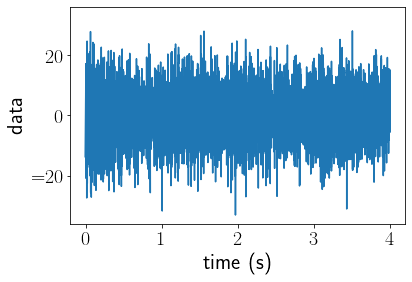

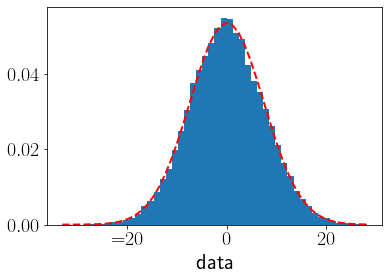

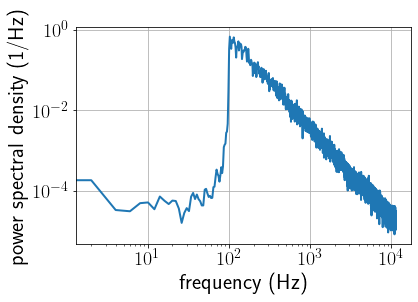

In [15]:
# BNS chirp (100)
random.seed(31459)
fileprefix = 'chirpBNS100'
tmin = 0
tmax = 4.
A = 1.
mass = 1.4
fcut = 100.
lambda_poisson = 100
Fs = 22500.

# simulate data of twice duration since duration of each chirp is > tmax
tt, yy = chirp(tmin, 2.*tmax, A, mass, fcut, 2.*lambda_poisson)
t = tt[0:int(len(tt)/2.)]
y = yy[0:int(len(tt)/2.)]
savetimeseries(t, y, fileprefix)
playsoundfile(fileprefix)
plottimeseries(t, y, t[0], t[-1], fileprefix)
plothistogram(t, y, t[0], t[-1], fileprefix) 
plotpowerspectrum(t, y, t[0], t[-1], Fs, fileprefix)

# BBH chirp signals

chirp duration = 0.18306011124997199


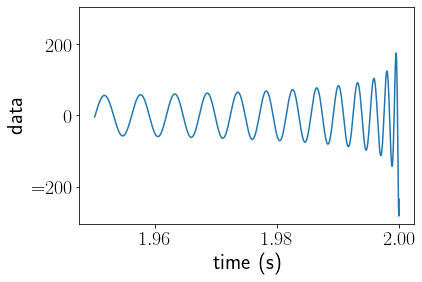

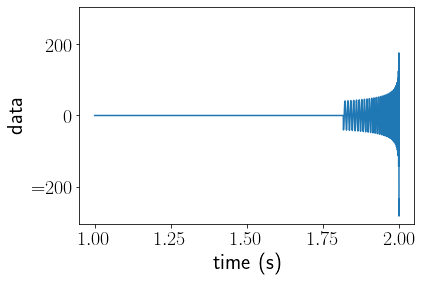

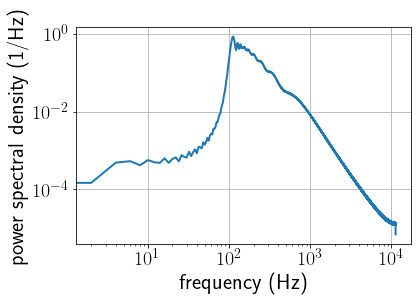

In [17]:
# single BBH chirp
fileprefix = 'chirpBBH'
tmin = 0
tmax = 4.
A = 1.
mass = 10. # BBH
t0 = 0.5*(tmin+tmax)
fcut = 100.
lambda_poisson = 0
Fs = 22500.

# calculate chirp duration (depends on Mc and fcut)
m = mass*5.e-6 # m1=m2=mass solar masses(in seconds)
Mc = m/pow(2,1./5.)     
tau = 1./pow(2.*np.pi*(8./5.)*pow(Mc,5./8.)*fcut,8./3.)
print('chirp duration =', tau)

t, y = chirp(tmin, tmax, A, mass, fcut, lambda_poisson)
savetimeseries(t, y, fileprefix)
playsoundfile(fileprefix)
plottimeseries(t, y, t0-0.05, t0, fileprefix+'_zoom')
plottimeseries(t, y, t0-1.0, t0, fileprefix)
plotpowerspectrum(t, y, tmin, tmax, Fs, fileprefix)

In [ ]:
# approximate power spectrum of BBH chirp f0 with a f^{-7/3} spectrum cutoff at f0 (stationary phase)
# NOTE: f^{-7/3} corresponds to Omega_gw ~ f^{2/3} and S_gw = Omega_gw/f^3
f0 = 100.
Fs = 22500.
fNyq = Fs/2.
tmin = 0.
tmax = 4. # max duration of signals

deltaF = 8.*(1./tmax) # multiply by 8 to agree with psd estimation
f = np.linspace(deltaF, fNyq, np.int(Fs/deltaF))

P = 1.e-4*np.ones(len(f))
ndx = np.where(f>=f0)[0]
P[ndx] = 1./pow(f[ndx]/f0,7./3.)

# plot power spectrum
filename = 'stationaryphase.pdf'
plt.figure()
plt.rc('text', usetex=True)
plt.tick_params(labelsize=20)
plt.loglog(f, P, linewidth=2)
plt.xlabel('frequency (Hz)', size=22)
plt.ylabel('PSD approximation', size=22)
plt.ylim([1e-5, 1])
plt.grid(True)
plt.savefig(filename, bbox_inches='tight', dpi=400)

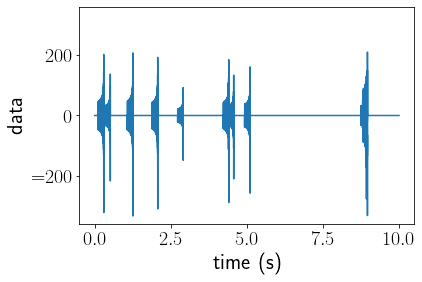

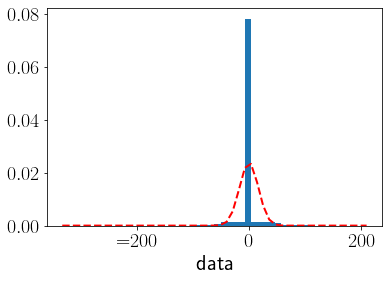

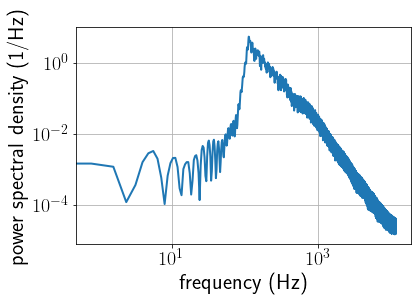

In [18]:
# BBH chirp (10 in 10 sec)
#random.seed(12345)
random.seed(3)
fileprefix = 'chirpBBH10_10s'
tmin = 0
tmax = 10.
A = 1.
mass = 10.
fcut = 100.
lambda_poisson = 10.
t1 = tmin
t2 = tmax
Fs = 22500.

t, y = chirp(tmin, tmax, A, mass, fcut, lambda_poisson)
savetimeseries(t, y, fileprefix)
playsoundfile(fileprefix)
plottimeseries(t, y, t1, t2, fileprefix)
plothistogram(t, y, t1, t2, fileprefix) 
plotpowerspectrum(t, y, tmin, tmax, Fs, fileprefix)

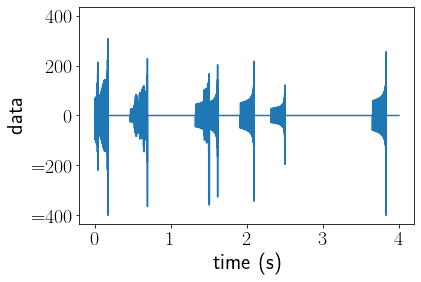

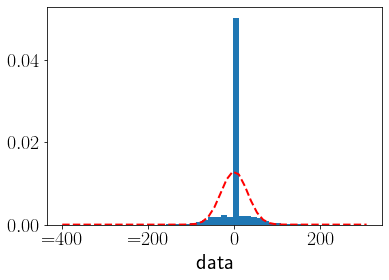

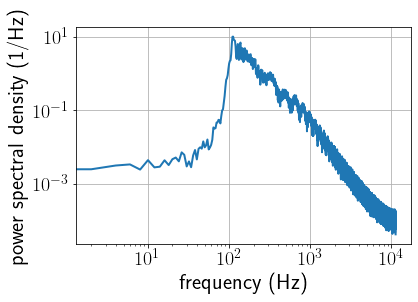

In [19]:
# BBH chirp (10)
random.seed(31459)
fileprefix = 'chirpBBH10'
tmin = 0
tmax = 4.
A = 1.
mass = 10.
fcut = 100.
lambda_poisson = 10.
t1 = tmin
t2 = tmax
Fs = 22500.

t, y = chirp(tmin, tmax, A, mass, fcut, lambda_poisson)
savetimeseries(t, y, fileprefix)
playsoundfile(fileprefix)
plottimeseries(t, y, t1, t2, fileprefix)
plothistogram(t, y, t1, t2, fileprefix) 
plotpowerspectrum(t, y, tmin, tmax, Fs, fileprefix)

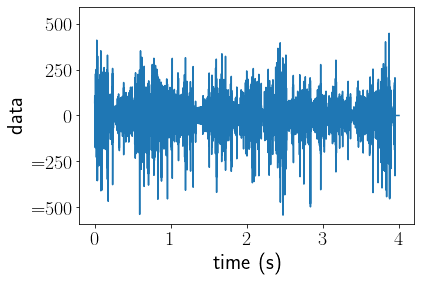

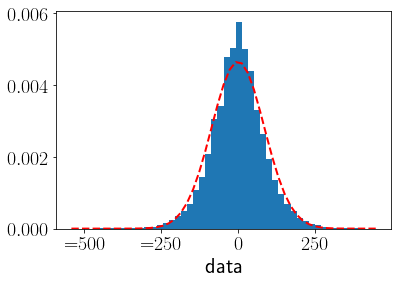

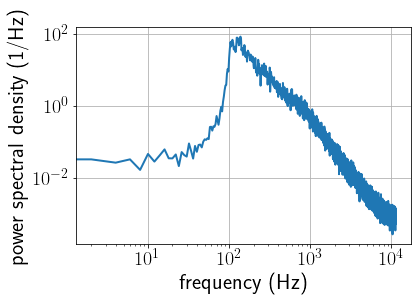

In [20]:
# BBH chirp (100)
random.seed(31459)
fileprefix = 'chirpBBH100'
tmin = 0
tmax = 4.
A = 1.
mass = 10.
fcut = 100.
lambda_poisson = 100.
t1 = tmin
t2 = tmax
Fs = 22500.

t, y = chirp(tmin, tmax, A, mass, fcut, lambda_poisson)
savetimeseries(t, y, fileprefix)
playsoundfile(fileprefix)
plottimeseries(t, y, t1, t2, fileprefix)
plothistogram(t, y, t1, t2, fileprefix) 
plotpowerspectrum(t, y, tmin, tmax, Fs, fileprefix)

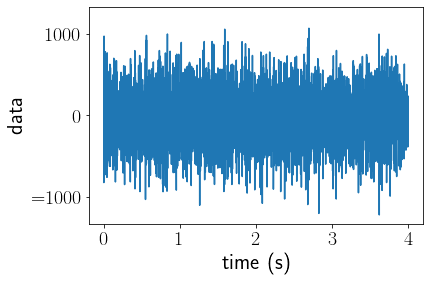

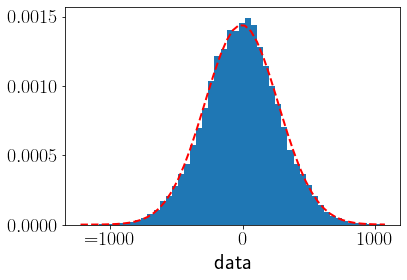

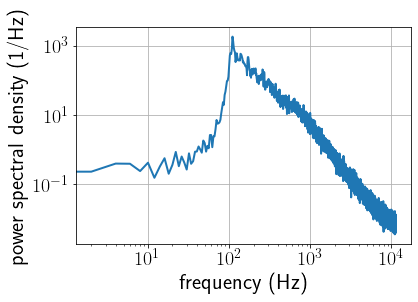

In [21]:
# BBH chirp (1000)
random.seed(31459)
fileprefix = 'chirpBBH1000'
tmin = 0
tmax = 4.
A = 1.
mass = 10.
fcut = 100.
lambda_poisson = 1000.
t1 = tmin
t2 = tmax
Fs = 22500.

t, y = chirp(tmin, tmax, A, mass, fcut, lambda_poisson)
savetimeseries(t, y, fileprefix)
playsoundfile(fileprefix)
plottimeseries(t, y, t1, t2, fileprefix)
plothistogram(t, y, t1, t2, fileprefix) 
plotpowerspectrum(t, y, tmin, tmax, Fs, fileprefix)

# ringdown signals

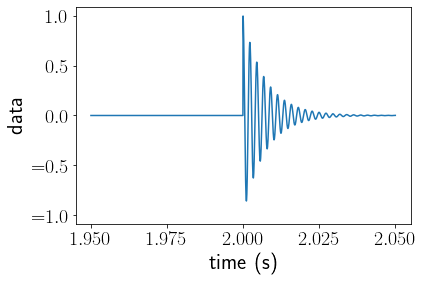

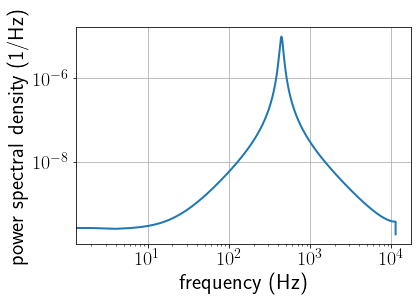

In [22]:
# single ringdown
fileprefix = 'ringdown'
tmin = 0
tmax = 4.
A = 1.
f0 = 440.
Q = 20.
lambda_poisson = 0
t0 = 2
t1 = t0-0.05
t2 = t0+0.05
Fs = 22500.

t, y = ringdown(tmin, tmax, A, f0, Q, lambda_poisson)
savetimeseries(t, y, fileprefix)
playsoundfile(fileprefix)
plottimeseries(t, y, t1, t2, fileprefix)
plotpowerspectrum(t, y, tmin, tmax, Fs, fileprefix)

/var/folders/mm/kvzrm4_d52z6vkt_1fl8thrh0000gn/T/ipykernel_75094/2146205910.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  f = np.linspace(deltaF, fNyq, np.int(Fs/deltaF))


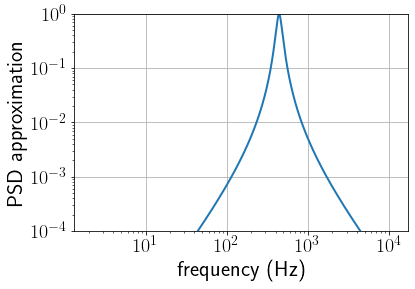

In [23]:
# approximate power spectrum of ringdown (f0, Q) a lorentzian
f0 = 440.
Q = 20. 
Fs = 22500.
fNyq = Fs/2.
tmin = 0.
tmax = 4. # max duration of signals

deltaF = 8.*(1./tmax) # multiply by 8 to agree with psd estimation
f = np.linspace(deltaF, fNyq, np.int(Fs/deltaF))

w = 2.*Q # width parameter
L = (w**2.)/((f-f0)**2 + w**2) # normalized to 1
ndx = np.where(f<f0)[0]
L[ndx]=((f[ndx]/f0)**2)*L[ndx]

# plot power spectrum
filename = 'lorentzian.pdf'
plt.figure()
plt.rc('text', usetex=True)
plt.tick_params(labelsize=20)
plt.loglog(f, L, linewidth=2)
plt.xlabel('frequency (Hz)', size=22)
plt.ylabel('PSD approximation', size=22)
plt.ylim([1e-4, 1])
plt.grid(True)
plt.savefig(filename, bbox_inches='tight', dpi=400)

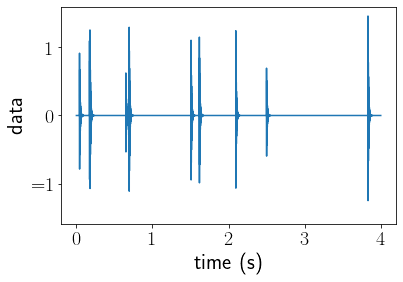

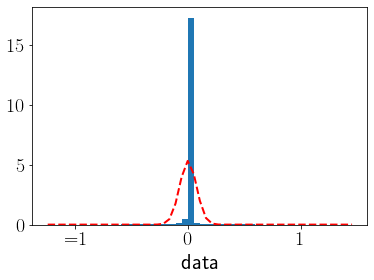

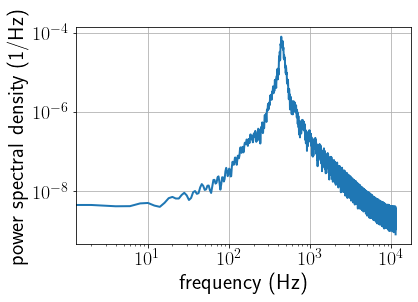

In [24]:
# ringdown (10)
random.seed(31459)
fileprefix = 'ringdown10'
tmin = 0
tmax = 4
A = 1.
f0 = 440.
Q = 20.
lambda_poisson = 10
t1 = tmin
t2 = tmax
Fs = 22500.

t, y = ringdown(tmin, tmax, A, f0, Q, lambda_poisson)
savetimeseries(t, y, fileprefix)
playsoundfile(fileprefix)
plottimeseries(t, y, t1, t2, fileprefix) 
plothistogram(t, y, t1, t2, fileprefix) 
plotpowerspectrum(t, y, tmin, tmax, Fs, fileprefix)

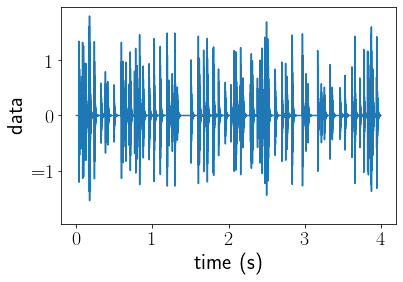

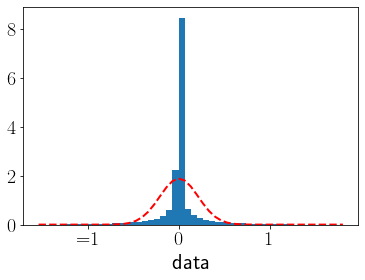

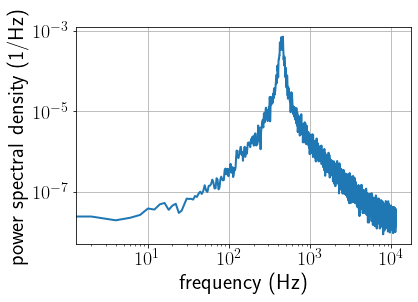

In [25]:
# ringdown (100)
random.seed(31459)
fileprefix = 'ringdown100'
tmin = 0
tmax = 4
A = 1.
f0 = 440.
Q = 20.
lambda_poisson = 100
t1 = tmin
t2 = tmax
Fs = 22500.

t, y = ringdown(tmin, tmax, A, f0, Q, lambda_poisson)
savetimeseries(t, y, fileprefix)
playsoundfile(fileprefix)
plottimeseries(t, y, t1, t2, fileprefix)  
plothistogram(t, y, t1, t2, fileprefix)
plotpowerspectrum(t, y, tmin, tmax, Fs, fileprefix)

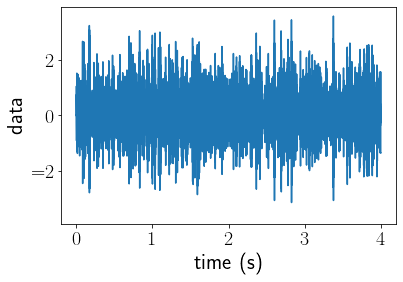

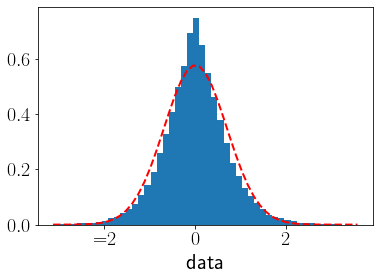

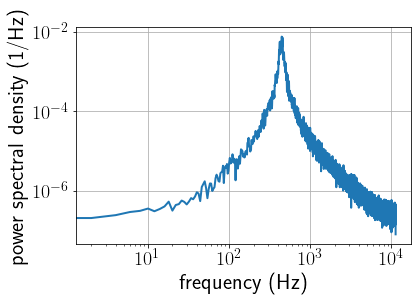

In [26]:
# ringdown (1000)
random.seed(31459)
fileprefix = 'ringdown1000'
tmin = 0
tmax = 4
A = 1.
f0 = 440.
Q = 20.
lambda_poisson = 1000
t1 = tmin
t2 = tmax
Fs = 22500.

t, y = ringdown(tmin, tmax, A, f0, Q, lambda_poisson)
savetimeseries(t, y, fileprefix)
playsoundfile(fileprefix)
plottimeseries(t, y, t1, t2, fileprefix)  
plothistogram(t, y, t1, t2, fileprefix) 
plotpowerspectrum(t, y, tmin, tmax, Fs, fileprefix)

In [ ]:
# ringdown (10000)
random.seed(31459)
fileprefix = 'ringdown10000'
tmin = 0
tmax = 4
A = 1.
f0 = 440.
Q = 20.
lambda_poisson = 10000
t1 = tmin
t2 = tmax
Fs = 22500.

t, y = ringdown(tmin, tmax, A, f0, Q, lambda_poisson)
savetimeseries(t, y, fileprefix)
playsoundfile(fileprefix)
plottimeseries(t, y, t1, t2, fileprefix)  
plothistogram(t, y, t1, t2, fileprefix) 
plotpowerspectrum(t, y, tmin, tmax, Fs, fileprefix)